In [194]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from utility import segmentation_utils

In [195]:
image = cv.imread('./mandarin.jpg')
scale_percent = 100
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv.resize(image, dim, interpolation = cv.INTER_AREA)
image_rgb = cv.cvtColor(resized, cv.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [196]:
def auto_segment(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, x10, y10,x11, y11,x12, y12, x13, y13,x14, y14,x15, y15, threshold):
    image_hsv = cv.cvtColor(image_rgb, cv.COLOR_RGB2HSV)
    # определяем координаты начальных точек
    seeds = [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5), (x6, y6), (x7, y7), (x8, y8), (x9, y9), (x10, y10), (x11, y11), (x12, y12), (x13, y13), (x14, y14), (x15, y15)]
    # координаты для графика
    x = list(map(lambda x: x[1], seeds))
    y = list(map(lambda x: x[0], seeds))
    # находим сегментацию используя метод из segmentation_utils
    segmented_region = segmentation_utils.region_growingHSV(image_hsv, seeds, threshold)
    # накладываем маску - отображаем только участки попавшие в какой-либо сегмент
    result = cv.bitwise_and(image_rgb, image_rgb, mask=segmented_region)
    # отображаем полученное изображение
    plt.figure(figsize=(15,20))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, marker="x", color="red", s=200)
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.show()

In [197]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [198]:
interact(auto_segment, x1=41, y1=132, x2=155, y2=91, x3=18, y3=223, x4=286, y4=48, x5=382, y5=153,x6=159, y6=217, x7=378, y7=213, x8=378, y8=34, x9=62, y9=29, x10=22, y10=29, x11=273, y11=150, x12=27, y12=7, x13=200, y13=14, x14=258, y14=259, x15=65, y15=259, threshold=90)

interactive(children=(IntSlider(value=41, description='x1', max=123, min=-41), IntSlider(value=132, descriptio…

<function __main__.auto_segment(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, threshold)>

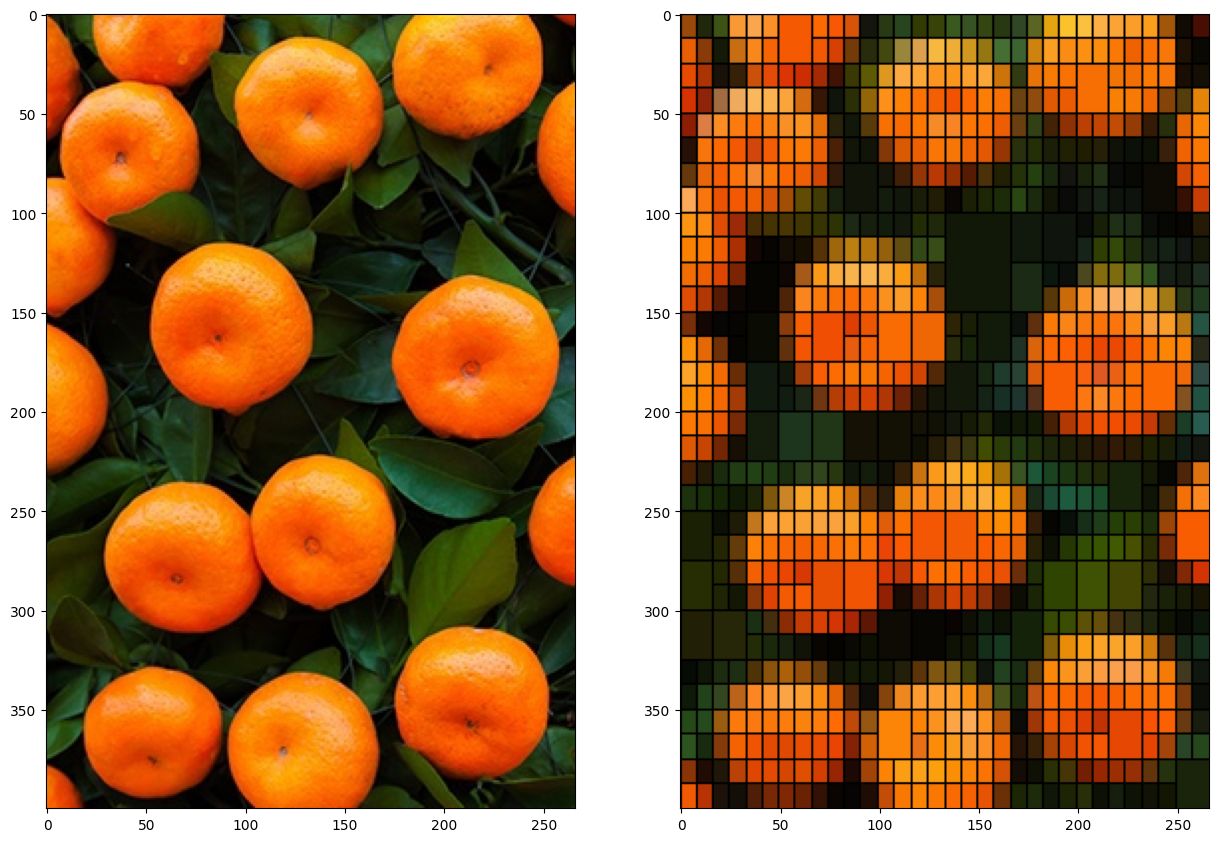

In [199]:
qt = segmentation_utils.QTree(stdThreshold = 0.25, minPixelSize = 4,img = image_rgb.copy()) 
qt.subdivide()
tree_image = qt.render_img(thickness=1, color=(0,0,0))

plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.subplot(1, 2, 2)
plt.imshow(tree_image)
plt.show()


In [200]:
gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)

In [201]:
from skimage.segmentation import watershed
from scipy import ndimage
from skimage.feature import peak_local_max

C:\Users\kasal\AppData\Local\Temp\ipykernel_17860\1095061560.py:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=15, labels=binary_image)
C:\Users\kasal\AppData\Local\Temp\ipykernel_17860\1095061560.py:16: RuntimeWarning: invalid value encountered in cast
  plt.imshow(np.uint8(distance_map + 50), cmap="gray")


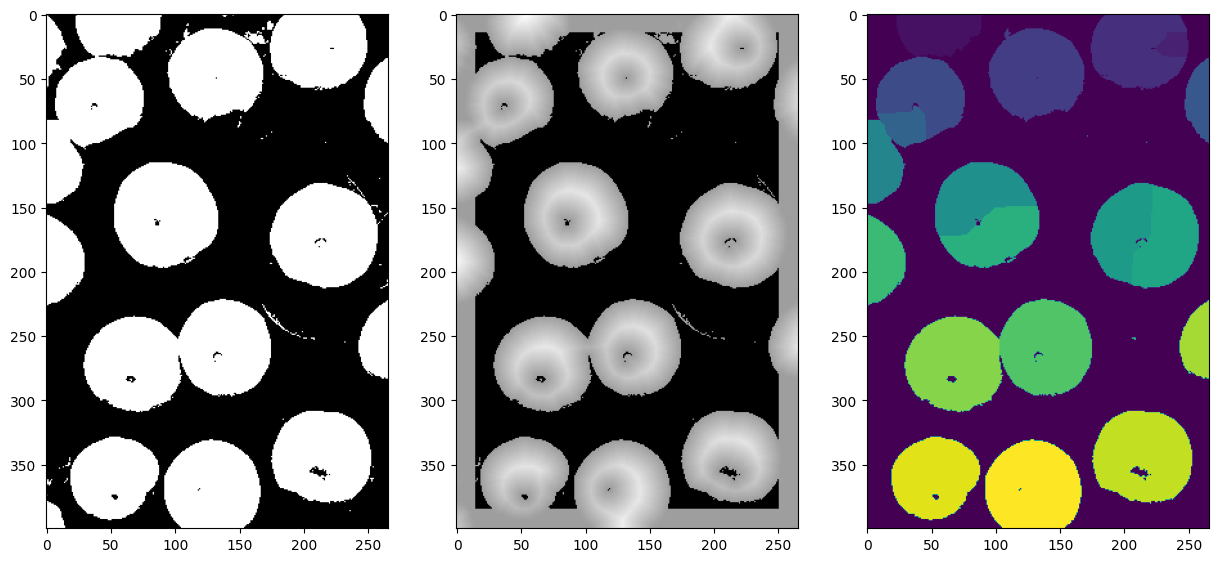

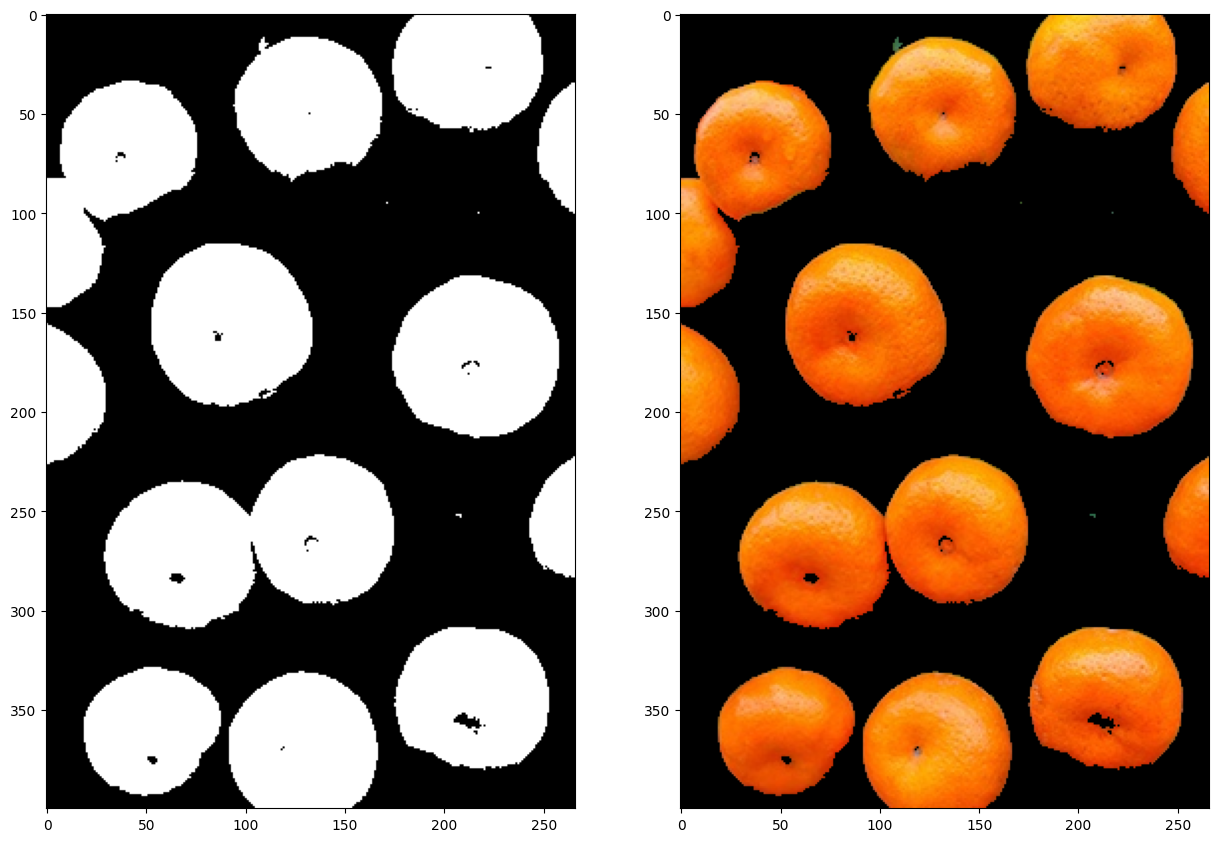

In [202]:
# Алгоритм водораздела
# Бинаризируем изображение
binary_image = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
# Определяем карту расстояний
distance_map = ndimage.distance_transform_edt(binary_image)
# Определяем локальные максимумы
local_max = peak_local_max(distance_map, indices=False, min_distance=15, labels=binary_image)
# 4 Каждому минимуму присваивается метка и начинается заполнение бассейнов метками
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=binary_image)
# построим результаты работы алгоритма
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(np.uint8(distance_map + 50), cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(np.uint8(labels))
plt.show()

# Найдем границы контуров и положим в маску все кроме метки 0
mask1 = np.zeros(image_rgb.shape[0:2], dtype="uint8")
total_area = 0
for label in np.unique(labels):
    if label < 2:
        continue
    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    mask1 = mask1 + mask

    # Find contours and determine contour area
    cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv.contourArea)
    area = cv.contourArea(c)
    total_area += area

result = cv.bitwise_and(image_rgb, image_rgb, mask=mask1)

plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.imshow(mask1, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

C:\Users\kasal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[[ 22]
 [148]
 [ 80]]


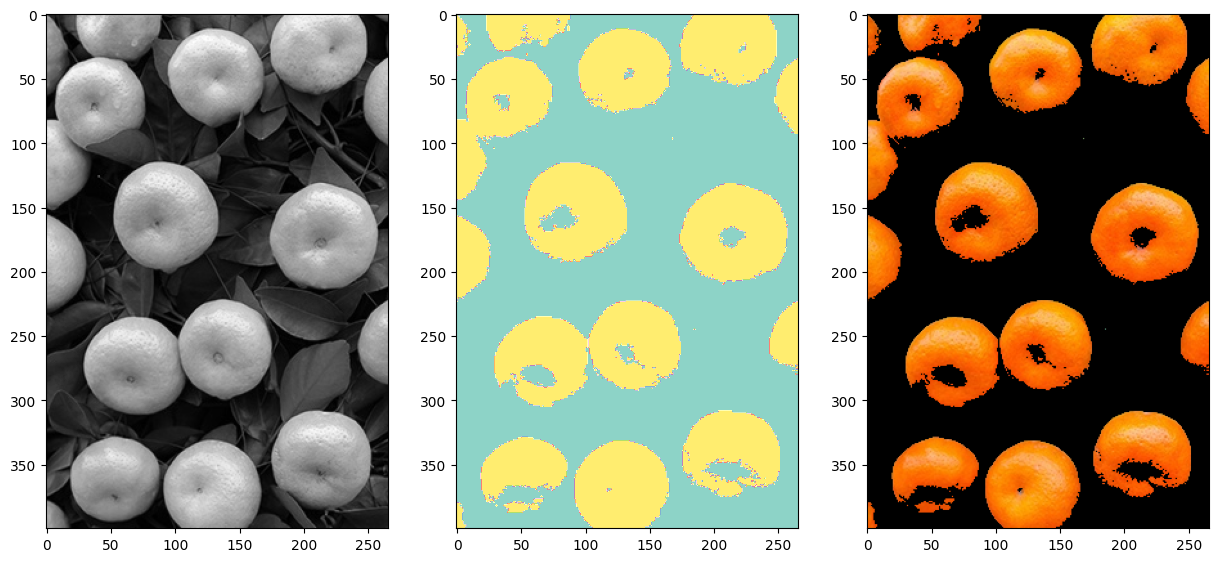

In [203]:
from sklearn.cluster import KMeans
## Методы кластеризации. K-средних
# Преобразуем изображение в оттенках серого в одномерный массив
pixels = gray.reshape(-1, 1)
# Задаем число кластеров для сегментации
K = 3
# С помощью библиотеки sklearn.cluster import KMeans проводим кластеризацию по яркости
kmeans = KMeans(n_clusters=K, random_state=0)
labels = kmeans.fit_predict(pixels)
cluster_centers = kmeans.cluster_centers_
print (np.uint8(cluster_centers))
# Каждому пикселю назначаем значение из центра кластера
segments = np.uint8(cluster_centers[labels].reshape(gray.shape))
# Удалим самые яркие пиксели
segments[(segments==22) | (segments==80)] = 0
result = cv.bitwise_and(image_rgb, image_rgb, mask=segments)
# Отобразим избражения 
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(segments, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(result)
plt.show()

In [204]:
from sklearn.cluster import MeanShift, estimate_bandwidth
blur_image = cv.medianBlur(image_rgb, 9)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1,3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_

# получим количество сегментов
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# получим средний цвет сегмента
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)
# Для каждого пискеля проставим средний цвет его сегмента
mean_shift_image = avg[labeled].reshape((image_rgb.shape))
# Маской скроем один из сегментов
mask1 = mean_shift_image[:,:,0]

Number of segments:  14


[[   18 34761]
 [   38  2846]
 [   47 14427]
 [   78  1301]
 [  115   852]
 [  123   151]
 [  160    41]
 [  171  3367]
 [  188   528]
 [  192   334]
 [  220     8]
 [  243 40508]
 [  252  7276]]


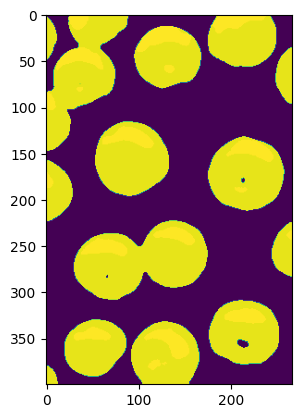

In [205]:
mask2=mask1.copy()
unique, counts = np.unique(mask2, return_counts=True)
print(np.asarray((unique, counts)).T)
mask2[(mask2==18)
      | (mask2==38)
      | (mask2==47)
     | (mask2==78)
     | (mask2==115)
     | (mask2==123)
     | (mask2==160)
     | (mask2==171)
     | (mask2==188)
     | (mask2==192)
     | (mask2==0)
     | (mask2==0)]= 0
plt.imshow(mask2)

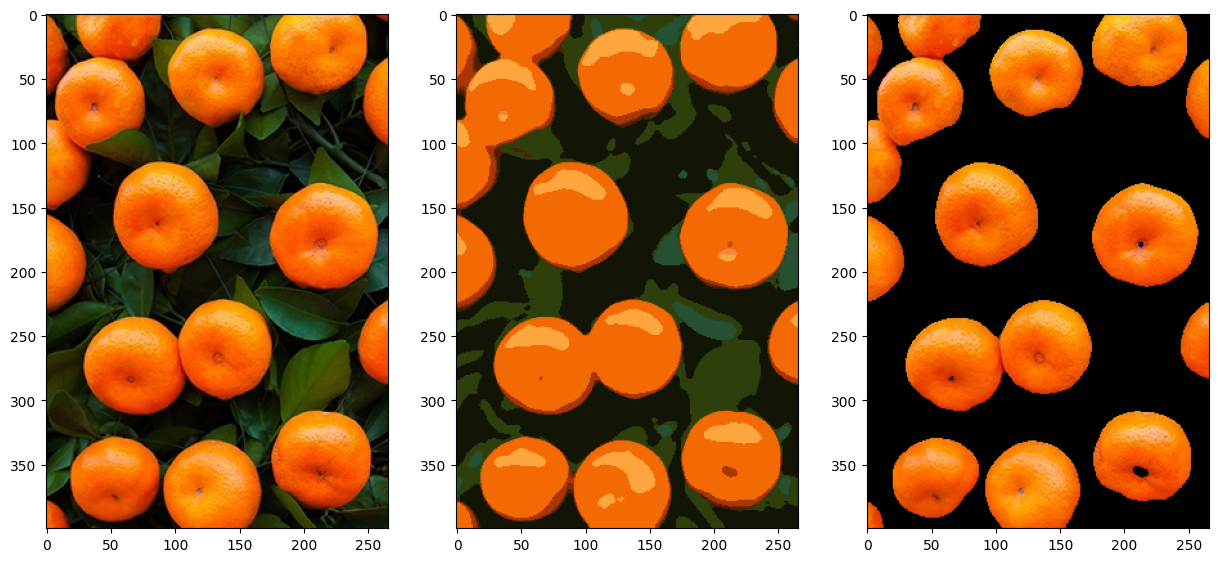

In [206]:
mean_shift_with_mask_image = cv.bitwise_and(image_rgb, image_rgb, mask=mask2)
# Построим изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.subplot(1, 3, 2)
plt.imshow(mean_shift_image, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(mean_shift_with_mask_image)
plt.show()